In [1]:
# Import the required modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\scmou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\scmou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# exploring fake job postings
fake_job_df = pd.read_csv("fake_job_postings.csv")
fake_job_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
#Replace NaNs with empty strings
fake_job_df.fillna("", inplace=True)
fake_job_df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [6]:

fake_job_df.fillna("", inplace=True)

# Combine text columns
fake_job_df["text"] = fake_job_df["title"] + " " + fake_job_df["company_profile"] + " " + fake_job_df["description"] + " " + fake_job_df["requirements"]

# Clean text
fake_job_df["text_cleaned"] = fake_job_df["text"].apply(clean_text)

# Add fraud-related features
fake_job_df["word_count"] = fake_job_df["text_cleaned"].apply(lambda x: len(x.split()))
fake_job_df["char_count"] = fake_job_df["text_cleaned"].apply(lambda x: len(x))
fake_job_df["contains_money_terms"] = fake_job_df["text_cleaned"].apply(lambda x: 1 if any(word in x for word in ["earn", "cash", "money", "pay"]) else 0)


In [5]:
stop_words = set(stopwords.words("english")) - {"urgent", "immediate", "hiring", "work", "money", "apply"}
# Remove special characters and numbers, set to lowercase and remove stopwords
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    cleaned_text = " ".join(word for word in text.split() if word not in stop_words)
    return cleaned_text

fake_job_df["text_cleaned"] =fake_job_df["text"].apply(clean_text)


In [7]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words
X = vectorizer.fit_transform(fake_job_df["text_cleaned"])

X = X.toarray()  # Convert sparse matrix to array
y = fake_job_df["fraudulent"]  # Target variable (1 = fake, 0 = real)


In [8]:
# Split into testing and training sets, limit test to 20%, stratify y for imbalance 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y) 

In [12]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# Apply SMOTE only to training set
smote = SMOTE(sampling_strategy=0.6, random_state=42)  # Increase synthetic minority class
undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Reduce but not too much

resampling_pipeline = Pipeline([
    ("smote", smote),
    ("under", undersample)
])
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)

c:\Users\scmou\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\scmou\anaconda3\envs\dev\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\scmou\anaconda3\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.

In [ ]:
#Decision tree model - train and fit
dt_model = DecisionTreeClassifier(max_depth=10, random_state=4)
dt_model.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=10, random_state=4)

In [ ]:
#Random forest model - train and fit
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=4)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=10, random_state=4)

In [11]:
#Make predictions on models
dt_preds = dt_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

In [12]:
#calculate accuracy and other metrics
print("Decision Tree Performance:")
print(classification_report(y_test, dt_preds))

print("Random Forest Performance:")
print(classification_report(y_test, rf_preds))


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3403
           1       0.48      0.58      0.52       173

    accuracy                           0.95      3576
   macro avg       0.73      0.77      0.75      3576
weighted avg       0.95      0.95      0.95      3576

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.88      0.54      0.67       173

    accuracy                           0.97      3576
   macro avg       0.93      0.77      0.83      3576
weighted avg       0.97      0.97      0.97      3576



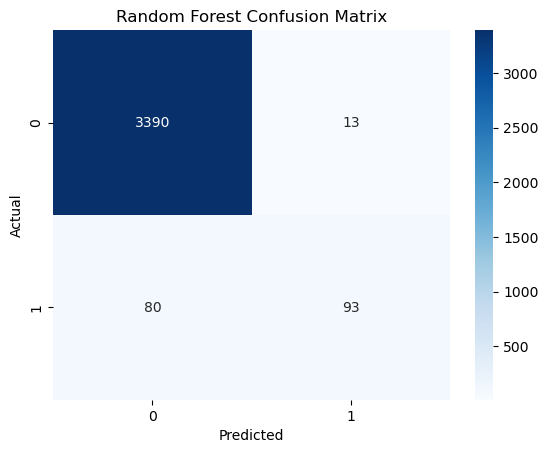

In [13]:
#plot confusion matrix 
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [14]:
#optimize model with Hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
}
rf_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters: ", rf_grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [16]:
grid_y_pred = rf_grid_search.predict(X_test)
print(classification_report(y_test, grid_y_pred,
                            target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.98      1.00      0.99      3403
    positive       0.98      0.68      0.80       173

    accuracy                           0.98      3576
   macro avg       0.98      0.84      0.90      3576
weighted avg       0.98      0.98      0.98      3576



In [ ]:
import joblib

joblib.dump(rf_grid_search, "pickles/rfc_grid_search.pkl")  # Save model
joblib.dump(vectorizer, "pickles/rfc_vectorizer.pkl")  # Save vectorizer

In [23]:
import joblib
# Load the trained model
model = joblib.load("fake_job_detector.pkl")

# Load the TF-IDF vectorizer
vectorizer = joblib.load("tfidf_vectorizer.pkl")

def predict_fraud(job_text):
    job_text = clean_text(job_text)  # Preprocess text
    job_vectorized = vectorizer.transform([job_text]).toarray()  # Convert to TF-IDF
    prediction = rf_grid_search.predict(job_vectorized)  # Predict
    return "Fake Job Posting" if prediction[0] == 1 else "Real Job Posting"

new_job = "Title: Remote Software Developer Needed – No Experience, High Pay! We are a top technology company looking for software engineers to work remotely on exciting projects! Looking for passionate individuals to work with global clients. No experience required—we provide full training! You will need to set up an account using your government ID for security verification. Must provide ID for security purposes No coding experience needed Must be available for an interview within 24 hours"
print(predict_fraud(new_job))

Real Job Posting
